# Stabilization of Finite Energy GKP
Connor Blake 6/2024 \
[ArXiv Paper](https://arxiv.org/pdf/2009.07941)
#### TODO
* recreate bath graphs
* show BsB visually
* X-basis verification

Notes:
* "_aa" indicates second quantization basis
* "_xx" indicates physical x basis
* "_01" indicates Pauli basis

In [1]:
from IPython.core.magic import register_cell_magic
from IPython import get_ipython
@register_cell_magic
def skip_if(line,cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)
skip_xx = False

## Setup

In [2]:
import qutip
from qutip import Qobj, tensor, basis
from qutip import *
import numpy as np
from numpy import kron
import scipy as sp
import pprint
import matplotlib.pyplot as plt

In [3]:
np.set_printoptions(precision=3)
from IPython.display import display, Latex, Math
def mat_print(array):
    matrix = ''
    for row in array:
        try:
            for number in row:
                matrix += f'{np.round(number,3)}&'
        except TypeError:
            matrix += f'{row}&'
        matrix = matrix[:-1] + r'\\'
    display(Math(r'\begin{bmatrix}'+matrix+r'\end{bmatrix}'))
def lat_print(val):
    display(Latex(val))

In [4]:
def R_x(theta):
    return sp.linalg.expm(-1j*theta*X_01/2.0)
def R_z(theta):
    return sp.linalg.expm(-1j*theta*Z_01/2.0)
def com_scalar(ai,bi):
    return ai*bi-bi*ai
def com_matrix(ai,bi):
    return ai@bi - bi@ai
def anticom_matrix(ai,bi):
    return ai@bi + bi@ai
def sin_matrix(ai):
    return 1/2.0/1j*(sp.linalg.expm(1j*ai)-sp.linalg.expm(-1j*ai))
def sawtooth_fourier(ai,ni,mi):
    # a is the matrix
    # ni is the fourier truncation
    # mi is the half-width of the pulse
    sum = 0
    arg_a = ai*2*np.pi/mi
    for k in range(1,ni+1):
        sum += ((-1)**k)/k*sin_matrix(arg_a*k)
    return -mi/np.pi*sum

## A-Basis

In [5]:
N = 170 # full computational
n = 25 # truncated for viewing / verification
hbar = 1
root2 = np.sqrt(2)
pi = np.pi
I_N = np.eye(N)
ket0 = np.array([[1],[0]])
ket1 = np.array([[0],[1]])
plus = (ket0+ket1)/root2
minus = (ket0-ket1)/root2
X_01 = np.array([[0,1],[1,0]])
Y_01 = np.array([[0,-1j],[1j,0]])
Z_01 = np.array([[1,0],[0,-1]])
I_01 = np.array([[1,0],[0,1]])
H_01 = np.array([[1,1],[1,-1]])/root2
a_aa = destroy(N).full()
a_dag_aa = create(N).full()
n_hat_aa = a_dag_aa@a_aa

In [6]:
def D_aa(alpha_i):
    return sp.linalg.expm(alpha_i*a_dag_aa - np.conjugate(alpha_i)*a_aa)
def CD_aa(beta_i):
    return sp.linalg.expm(np.kron((beta_i*a_dag_aa - np.conjugate(beta_i)*a_aa),Z_01)/(2*root2))
def S_aa(xi):
    return sp.linalg.expm(np.conjugate(xi)*(a_aa@a_aa)-xi*(a_dag_aa@a_dag_aa))

### Setup Variables (Exact GKP)

In [7]:
x_aa = (a_aa+a_dag_aa)/root2 # _aa on all variables represent in a, a_dagger basis (second quantization)
p_aa = -1j*(a_aa-a_dag_aa)/root2
l = 2*np.sqrt(pi)
alpha = l*np.array([0,1])
beta =  l*np.array([-1,0])
l_j = np.array([np.sqrt(alpha[0]**2+beta[0]**2),np.sqrt(alpha[1]**2 + beta[1]**2)])
q_j_aa =      np.array([alpha[0]*x_aa + beta[0]*p_aa, 
                     alpha[1]*x_aa + beta[1]*p_aa])
q_j_perp_aa = np.array([alpha[0]*p_aa - beta[0]*x_aa,
                     alpha[1]*p_aa - beta[1]*x_aa])
omega_12 = alpha[0]*beta[1]-beta[0]*alpha[1]
T_i_0_aa = np.array([sp.linalg.expm(1j*q_j_aa[0]),sp.linalg.expm(1j*q_j_aa[1])])
X_0_aa = sp.linalg.fractional_matrix_power(T_i_0_aa[0],.5) # this leads to some kind of numerical error which fails commutation
Z_0_aa = sp.linalg.fractional_matrix_power(T_i_0_aa[1],.5) # ditto
X_0_aa = sp.linalg.expm(1j*q_j_aa[0]/2.0)
Z_0_aa = sp.linalg.expm(1j*q_j_aa[1]/2.0)
Y_0_aa = sp.linalg.expm(1j*(q_j_aa[0]+q_j_aa[1])/2.0)
fourier_trunc = 60
x_j_aa = np.array([q_j_aa[0]/l_j[0],q_j_aa[1]/l_j[1]])
x_j_perp_aa = np.array([q_j_perp_aa[0]/l_j[0],q_j_perp_aa[1]/l_j[1]])
x_j_m_aa = np.array([sawtooth_fourier(x_j_aa[0],fourier_trunc,2*pi/l_j[0]),
                     sawtooth_fourier(x_j_aa[1],fourier_trunc,2*pi/l_j[1])])

### Verifying Exact GKP Variables

In [8]:
lat_print("$[q_j,q_{j,perp}]= i (a_j^2 + b_j^2)$?")
com_0 = com_matrix(q_j_aa[0],q_j_perp_aa[0])
com_1 = com_matrix(q_j_aa[1],q_j_perp_aa[1])
print(np.all(np.isclose(np.diag(com_0)[:n],1j*(alpha[0]**2+beta[0]**2))))
print(np.all(np.isclose(np.diag(com_0)[:n],1j*(alpha[0]**2+beta[0]**2))))
lat_print("$[x_j,x_{j,perp}]= i$?")
com_0 = com_matrix(x_j_aa[0],x_j_perp_aa[0])
com_1 = com_matrix(x_j_aa[1],x_j_perp_aa[1])
print(np.all(np.isclose(np.diag(com_0)[:n],1j)))
print(np.all(np.isclose(np.diag(com_0)[:n],1j)))
lat_print("$T_{j,0} = e^{i q_j} = D((- b_j + i a_j) / \\sqrt{2} ) $?")
print(np.allclose(T_i_0_aa[0], D_aa((-beta[0]+1j*alpha[0])/root2)))
print(np.allclose(T_i_0_aa[1], D_aa((-beta[1]+1j*alpha[1])/root2)))
lat_print("$\\omega_{12} = 4 \\pi?$")
print(np.isclose(omega_12,4*pi))
lat_print("$[T_{1,0},T_{2,0}] = 0$?")
c0 = T_i_0_aa[0]@T_i_0_aa[1]
c1 = T_i_0_aa[1]@T_i_0_aa[0]
print(np.allclose(c0[:n,:n],c1[:n,:n]))
lat_print("$X_0 = \\sqrt{T_{1,0}} = e^{iq_1/2}$?")
exp_def_0 = sp.linalg.expm(1j*q_j_aa[0]/2.0)
print(np.allclose(X_0_aa[:n,:n],exp_def_0[:n,:n]))
lat_print("$Z_0 = \\sqrt{T_{2,0}} = e^{iq_2/2}$?")
exp_def_1 = sp.linalg.expm(1j*q_j_aa[1]/2.0)
print(np.allclose(Z_0_aa[:n,:n],exp_def_1[:n,:n]))
lat_print("$[X_0,T_{2,0}]=0$?")
X_T2_com = com_matrix(X_0_aa,T_i_0_aa[1])
print(np.allclose(X_T2_com[:n,:n],np.zeros((n,n))))
lat_print("$[X_0,T_{1,0}]=0$?")
X_T1_com = com_matrix(X_0_aa,T_i_0_aa[0])
print(np.allclose(X_T1_com[:n,:n],np.zeros((n,n))))
lat_print("$[Z_0,T_{1,0}]=0$?")
Z_T1_com = com_matrix(Z_0_aa,T_i_0_aa[0])
print(np.allclose(Z_T1_com[:n,:n],np.zeros((n,n))))
lat_print("$[Z_0,T_{2,0}]=0$?")
Z_T2_com = com_matrix(Z_0_aa,T_i_0_aa[1])
print(np.allclose(Z_T2_com[:n,:n],np.zeros((n,n))))
lat_print("$\\{Z_0,X_0\\}=0$?")
X_Z_anticom = anticom_matrix(X_0_aa,Z_0_aa)
print(np.allclose(X_Z_anticom[:n,:n],np.zeros((n,n))))
lat_print("$Y_0 = -i Z_0 X_0$?")
prod = -1j*Z_0_aa@X_0_aa
print(np.allclose(Y_0_aa[:n,:n],prod[:n,:n]))
lat_print("$\\ln T_{j,0} = i l_j x_{j,[2\\pi/l_j]}$? ($\\pm .05$)")
eps = .05
log_T_0 = sp.linalg.logm(T_i_0_aa[0])
log_T_1 = sp.linalg.logm(T_i_0_aa[1])
rhs_0 = 1j*l_j[0]*x_j_m_aa[0]
rhs_1 = 1j*l_j[1]*x_j_m_aa[1]
print(np.allclose(log_T_0[:n,:n],rhs_0[:n,:n],atol=eps))
print(np.allclose(log_T_1[:n,:n],rhs_1[:n,:n],atol=eps))

<IPython.core.display.Latex object>

True
True


<IPython.core.display.Latex object>

True
True


<IPython.core.display.Latex object>

True
True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True
True


### Setup Variables (Finite Energy GKP)

In [9]:
Delta = .2
c_Delta = np.cosh(Delta**2)
s_Delta = np.sinh(Delta**2)
t_Delta = np.tanh(Delta**2)
m_j = 2*pi/c_Delta/l_j
E_D_aa = sp.linalg.expm(-Delta**2*n_hat_aa)
E_D_aa_inv = np.linalg.inv(E_D_aa)
T_i_E_aa = np.array([np.dot(E_D_aa,T_i_0_aa[0]@E_D_aa_inv), np.dot(E_D_aa,T_i_0_aa[1]@E_D_aa_inv)])
d_j_E_aa = 1.0/root2*(x_j_m_aa/np.sqrt(t_Delta) + 1j*x_j_perp_aa*np.sqrt(t_Delta))
d_j_E_dag_aa = np.array([np.conjugate(d_j.T) for d_j in d_j_E_aa])
d_j_E_prod_aa = np.array([d_j_E_dag_aa[j]@d_j_E_aa[j] for j in [0,1]])
# TODO: implement {X, Y, Z}_E_aa

### Finite State Verification (a-basis)

In [10]:
lat_print("$ET_{i,0}E^{-1} = e^{EqE^{-1}}$?")
exp_form_0 = sp.linalg.expm(1j*E_D_aa@(q_j_aa[0]@E_D_aa_inv))
print(np.allclose(T_i_E_aa[0][:n,:n],exp_form_0[:n,:n]))
exp_form_1 = sp.linalg.expm(1j*E_D_aa@(q_j_aa[1]@E_D_aa_inv))
print(np.allclose(T_i_E_aa[1][:n,:n],exp_form_1[:n,:n]))
lat_print("$[T_{1,E},T_{2,E}] = 0$?")
com = com_matrix(T_i_E_aa[0],T_i_E_aa[1])
print(np.allclose(com[:n,:n],np.zeros((n,n))))
lat_print("$T_{j,E}=e^{\\cosh(\\Delta^2)\\sinh(\\Delta^2)l_j^2/2}e^{-q_{j,perp}\\sinh(\\Delta^2)}e^{iq_j\\cosh(\\Delta^2)}$?")
exp_def_0 = np.exp(c_Delta*s_Delta*l_j[0]**2/2)*(sp.linalg.expm(-q_j_perp_aa[0]*s_Delta)@sp.linalg.expm(1j*q_j_aa[0]))
print(np.allclose(T_i_E_aa[0][:n,:n],exp_def_0[:n,:n],atol=.01))
exp_def_1 = np.exp(c_Delta*s_Delta*l_j[1]**2/2)*(sp.linalg.expm(-q_j_perp_aa[1]*s_Delta)@sp.linalg.expm(1j*q_j_aa[1]))
print(np.allclose(T_i_E_aa[1][:n,:n],exp_def_1[:n,:n],atol=.01))
# TODO verify computational basis

<IPython.core.display.Latex object>

True
True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True
True


### Markovian Dynamics

In [11]:
Gamma = 10  # free parameter
Gamma_j = np.array([Gamma,Gamma])
T = 10
epsilon_j = s_Delta*l_j
theta_j = np.angle(alpha+1j*beta)
Gamma_dt = t_Delta/4*c_Delta**2*l_j**2
dt = Gamma_dt[0]/Gamma
t_f = dt*T
b_k = (X_01 + 1j*Y_01)/2 # typo in paper
b_dag_k = np.conjugate(b_k.T)

In [12]:
def dissipation_super(op,op_dag,op_dag_op,rho):
    rho_dot = op@(rho@op_dag) - .5*anticom_matrix(op_dag_op,rho)
    return rho_dot
def master(rho):
    return Gamma_j[0]*dissipation_super(d_j_E_aa[0],d_j_E_dag_aa[0],d_j_E_prod_aa[0],rho) + Gamma_j[1]*dissipation_super(d_j_E_aa[1],d_j_E_dag_aa[1],d_j_E_prod_aa[1],rho)

In [13]:
H_E_n_aa = np.sqrt(Gamma)*(np.kron(d_j_E_aa[0],b_dag_k) + np.kron(d_j_E_dag_aa[0],b_k)) # TODO figure out [1]
U_n_aa01 = sp.linalg.expm(-1j*np.sqrt(dt)*H_E_n_aa)
U_n_dag_aa01 = np.conj(U_n_aa01.T)
U_T_aa01 = np.linalg.matrix_power(U_n_aa01,T)

### Markov Verification

In [14]:
lat_print("$[b_n,b_n^{\\dagger}] = \\sigma_z$?")
print(np.allclose(com_matrix(b_k,b_dag_k),Z_01))
lat_print("$U_n$ unitary?")
print(np.isclose(1,np.abs(np.linalg.det(U_n_aa01))))
lat_print("$U_n^{\\dagger}$ unitary?")
print(np.isclose(1,np.abs(np.linalg.det(U_n_dag_aa01))))
lat_print("$U_T$ unitary?")
print(np.isclose(1,np.abs(np.linalg.det(U_T_aa01))))
lat_print("$\\Gamma_j\\delta t=t_{\\Delta}c_{\\Delta}^2l_j^2/4$?")
print(np.allclose(Gamma_j*dt,t_Delta/4*c_Delta**2*l_j**2))

<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


### Control Schemes

In [15]:
CD_A_aa = np.array([CD_aa(epsilon_j[j]*np.exp(1j*theta_j[j])) for j in [0,1]])
CD_B_aa = np.array([CD_aa(-1j*(alpha[j]+1j*beta[j])*c_Delta) for j in [0,1]])
CD_A2_aa = np.array([CD_aa(epsilon_j[j]*np.exp(1j*theta_j[j])/2) for j in [0,1]])

U_st_1_aa = np.array([(sp.linalg.expm(-1j*epsilon_j[j]/2*np.kron(x_j_perp_aa[j],Y_01)))@
                      (sp.linalg.expm(-1j*l_j[j]*c_Delta/2*np.kron(x_j_aa[j],X_01))) for j in [0,1]])
U_st_2_aa = np.array([(sp.linalg.expm(-1j*l_j[j]*c_Delta/2*np.kron(x_j_aa[j],X_01)))@
                      (sp.linalg.expm(-1j*epsilon_j[j]/2*np.kron(x_j_perp_aa[j],Y_01))) for j in [0,1]])

U_ST_1_aa01 = np.array([CD_A_aa[j]@(
                        np.kron(np.eye(N),np.conj(R_x(pi/2).T))@
                        CD_B_aa[j]) for j in [0,1]])
U_ST_1_dag_aa01 = np.array([np.conj(U_i.T) for U_i in U_ST_1_aa01])
U_ST_2_aa01 = np.array([CD_B_aa[j]@(
                        np.kron(np.eye(N),R_x(pi/2))@
                        CD_A_aa[j]) for j in [0,1]])
U_ST_2_dag_aa01 = np.array([np.conj(U_i.T) for U_i in U_ST_2_aa01])
U_sBs_aa01 = np.array([CD_A2_aa[j]@(
                    np.kron(np.eye(N),np.conj(R_x(pi/2).T))@(
                    CD_B_aa[j]@(
                    np.kron(np.eye(N),R_x(pi/2))@
                    CD_A2_aa[j])))for j in [0,1]])

### Control Verification

In [16]:
lat_print("$e^{im_j x_{j,perp}}U^{ST}_ie^{-im_jx_{j,perp}}=-U^{ST}_i$?")
prod_1 = np.array([np.kron(sp.linalg.expm(1j*m_j[j]*x_j_perp_aa[j]),I_01)@
                   (U_st_1_aa[j]@np.kron(sp.linalg.expm(-1j*m_j[j]*x_j_perp_aa[j]),I_01)) for j in [0,1]])
print(np.allclose(prod_1[0][:2*n,:2*n],-U_st_1_aa[0][:2*n,:2*n]))
print(np.allclose(prod_1[1][:2*n,:2*n],-U_st_1_aa[1][:2*n,:2*n]))
prod_2 = np.array([np.kron(sp.linalg.expm(1j*m_j[j]*x_j_perp_aa[j]),I_01)@
                   (U_st_2_aa[j]@np.kron(sp.linalg.expm(-1j*m_j[j]*x_j_perp_aa[j]),I_01)) for j in [0,1]])
print(np.allclose(prod_2[0][:2*n,:2*n],-U_st_2_aa[0][:2*n,:2*n]))
print(np.allclose(prod_2[1][:2*n,:2*n],-U_st_2_aa[1][:2*n,:2*n]))
lat_print("$\\sigma_x = H \\sigma_z H$?")
print(np.allclose(X_01,H_01@(Z_01@H_01)))
lat_print("$\\sigma_y = R_z(\\pi/2)H\\sigma_zHR_z^{\\dagger}(\\pi/2)$?")
print(np.allclose(Y_01,R_z(pi/2)@(H_01@(Z_01@(H_01@np.conj(R_z(pi/2).T))))))
lat_print("$U^{ST}_1 = CD(\\epsilon_je^{i\theta_j})R_x^{\\dagger}(\\pi/2)CD(-il_je^{i\\theta_j}c_{\\Delta})$ (up to ancilla)?")
def_1 = np.array([np.kron(np.eye(N),R_z(pi/2))@( # only on ancilla, ignore
                    np.kron(np.eye(N),H_01)@( # only on ancilla, ignore
                    U_ST_1_aa01[j]@(
                    np.kron(np.eye(N),H_01) # only on ancilla, ignore
                  ))) for j in [0,1]])
print(np.allclose(def_1[0][:2*n,:2*n],U_st_1_aa[0][:2*n,:2*n]))
print(np.allclose(def_1[1][:2*n,:2*n],U_st_1_aa[1][:2*n,:2*n]))
lat_print("$U^{ST}_2 = CD(-il_je^{itheta_j}c_{\\Delta})R_x(\\pi/2)CD(\\epsilon_je^{i\\theta_j})$ (up to ancilla)?")
def_2 = np.array([  np.kron(np.eye(N),H_01)@( # ignore ancilla
                    U_ST_2_aa01[j]@(
                    np.kron(np.eye(N),H_01)@( # ignore ancilla
                    np.kron(np.eye(N),np.conj(R_z(pi/2).T)) # ignore ancilla
                    ))) for j in [0,1]])
print(np.allclose(def_2[0][:2*n,:2*n],U_st_2_aa[0][:2*n,:2*n]))
print(np.allclose(def_2[1][:2*n,:2*n],U_st_2_aa[1][:2*n,:2*n]))
lat_print("$U^{ST,\\dagger} = (U^{ST})^{\\dagger}$?")
print(np.allclose(U_ST_1_aa01[0],np.conj(U_ST_1_dag_aa01[0].T)))
print(np.allclose(U_ST_2_aa01[0],np.conj(U_ST_2_dag_aa01[0].T)))
print(np.allclose(U_ST_1_aa01[1],np.conj(U_ST_1_dag_aa01[1].T)))
print(np.allclose(U_ST_2_aa01[1],np.conj(U_ST_2_dag_aa01[1].T)))
lat_print("$U^{ST}_i$ unitary?")
print(np.isclose(1,np.abs(np.linalg.det(U_st_1_aa[0]))))
print(np.isclose(1,np.abs(np.linalg.det(U_st_1_aa[1]))))
print(np.isclose(1,np.abs(np.linalg.det(U_st_2_aa[0]))))
print(np.isclose(1,np.abs(np.linalg.det(U_st_2_aa[1]))))
lat_print("$\\epsilon_j = \\sinh(\\Delta^2)4\\pi/l_j$")
print([np.isclose(epsilon_j[j],s_Delta*4*pi/l_j[j]) for j in [0,1]])
lat_print(f"$\\Gamma = {np.round(Gamma,3)}$")
lat_print(f"$\\delta t = {np.round(dt,3)}$")

<IPython.core.display.Latex object>

True
True
True
True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True
True


<IPython.core.display.Latex object>

True
True


<IPython.core.display.Latex object>

True
True
True
True


<IPython.core.display.Latex object>

True
True
True
True


<IPython.core.display.Latex object>

[True, True]


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## X-Basis

In [17]:
%%skip_if skip_xx

N_states = 15 # "infinite" dirac comb
x_per_state = 50
N_x = x_per_state*N_states # x-basis discretization
max_x_x = N_states/2*l_j[0]
x_x = np.linspace(-max_x_x,max_x_x,N_x)
dx = x_x[1]-x_x[0]
x_xx = np.diag(x_x) # <x'|x_hat|x> diagonal matrix

In [18]:
%%skip_if skip_xx


def D_xx(alpha_i):
    return sp.linalg.expm(alpha_i*a_dag_xx - np.conjugate(alpha_i)*a_xx)
def CD_xx(beta_i):
    return sp.linalg.expm(np.kron((beta_i*a_dag_xx - np.conjugate(beta_i)*a_xx),Z_01)/(2*root2))
def S_xx(xi):
    return sp.linalg.expm(np.conjugate(xi)*(a_xx@a_xx)-xi*(a_dag_xx@a_dag_xx))

First Derivative Matrix

In [19]:
%%skip_if skip_xx

# bad root circulant Laplacian matrix
#L_xx = np.zeros((N_x,N_x))
#np.fill_diagonal(L_xx,2)
#np.fill_diagonal(L_xx[1:,:],-1)
#np.fill_diagonal(L_xx[:,1:],-1)
#L_xx[N_x-1,0] = -1
#L_xx[0,N_x-1] = -1
#L_xx /= dx**2
#D_xx = sp.linalg.fractional_matrix_power(L_xx,.5)

# circulant 2nd order centered finite difference
D_xx = np.zeros((N_x,N_x))
np.fill_diagonal(D_xx[2:,:],-1)
np.fill_diagonal(D_xx[:,N_x-2:],-1)
np.fill_diagonal(D_xx[1:,:],8)
D_xx[0,N_x-1] = 8
np.fill_diagonal(D_xx[:,1:],-8)
D_xx[N_x-1,0] = -8
np.fill_diagonal(D_xx[:,2:],1)
np.fill_diagonal(D_xx[N_x-2:,:],1)
D_xx /= -12*dx

In [20]:
%%skip_if skip_xx

p_xx = -1j*hbar*D_xx

### Ideal

In [21]:
%%skip_if skip_xx

Psi_0j_x = np.array([1 if (i % x_per_state ==0) else 0 for i in range(N_x)])  # <x'|Psi_0,j> = Psi_0,0,j(x'), all j states same
Psi_0j_x_norm = np.sqrt(np.trace(np.outer(Psi_0j_x,Psi_0j_x)))
Psi_0j_x = Psi_0j_x/Psi_0j_x_norm

DFT to get $<p'|\Psi_{0,j}>$

In [22]:
%%skip_if skip_xx

# TODO something's off here
p_x = np.zeros((N_x,1))
M_DFT = np.zeros((N_x,N_x),dtype=complex)
omega = np.exp(-pi*2j/N_x)
for j in range(N_x):
    for k in range(N_x):
        M_DFT[j,k] = omega**(j*k)
        M_DFT[k,j] = M_DFT[j,k]
U_DFT = M_DFT/np.sqrt(N_x)
Psi_0j_p = U_DFT@Psi_0j_x

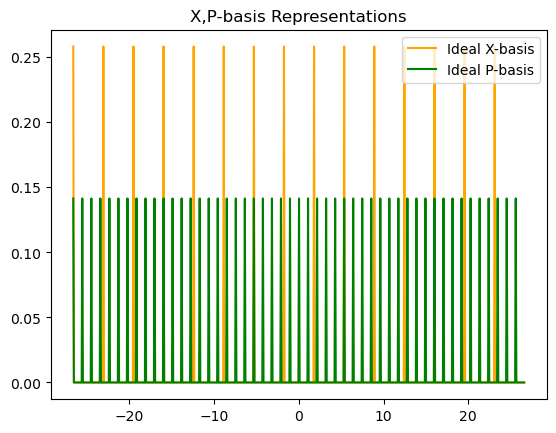

In [23]:
%%skip_if skip_xx

plt.plot(x_x,Psi_0j_x,color='orange',label="Ideal X-basis")
plt.plot(x_x,np.real(Psi_0j_p),color='green',label="Ideal P-basis")
plt.title("X,P-basis Representations")
plt.legend()
plt.show()

In [24]:
%%skip_if skip_xx

a_xx =     (x_xx+1j*p_xx)/root2
a_dag_xx = (x_xx-1j*p_xx)/root2
n_hat_xx = a_dag_xx@a_xx

In [25]:
%%skip_if skip_xx

q_j_xx =      np.array([alpha[0]*x_xx + beta[0]*p_xx, 
                     alpha[1]*x_xx + beta[1]*p_xx])
q_j_perp_xx = np.array([alpha[0]*p_xx - beta[0]*x_xx,
                     alpha[1]*p_xx - beta[1]*x_xx])
T_i_0_xx = np.array([sp.linalg.expm(1j*q_j_xx[0]),sp.linalg.expm(1j*q_j_xx[1])])
X_0_xx = sp.linalg.fractional_matrix_power(T_i_0_xx[0],.5) # this leads to some kind of numerical error which fails commutation
Z_0_xx = sp.linalg.fractional_matrix_power(T_i_0_xx[1],.5) # ditto
X_0_xx = sp.linalg.expm(1j*q_j_xx[0]/2.0)
Z_0_xx = sp.linalg.expm(1j*q_j_xx[1]/2.0)
Y_0_xx = sp.linalg.expm(1j*(q_j_xx[0]+q_j_xx[1])/2.0)

### Finite

In [26]:
%%skip_if skip_xx

E_D_xx = sp.linalg.expm(-Delta**2*n_hat_xx)
E_D_xx_inv = np.linalg.inv(E_D_xx)
T_i_E_xx = np.array([np.dot(E_D_xx,T_i_0_xx[0]@E_D_xx_inv), np.dot(E_D_xx,T_i_0_xx[1]@E_D_xx_inv)])
Psi_Ej_x = E_D_xx@Psi_0j_x
Psi_Ej_x_norm = np.sqrt(np.trace(np.outer(Psi_Ej_x,Psi_Ej_x)))
Psi_Ej_x = Psi_Ej_x/Psi_Ej_x_norm
Psi_Ej_p = U_DFT@Psi_Ej_x

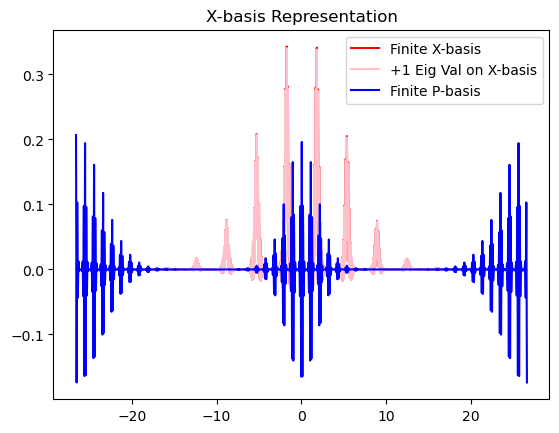

In [27]:
%%skip_if skip_xx

plt.plot(x_x,np.real(Psi_Ej_x),color='red',label="Finite X-basis")
plt.plot(x_x,np.real(T_i_E_xx[1]@Psi_Ej_x),color='pink',label="+1 Eig Val on X-basis")
plt.plot(x_x,np.real(Psi_Ej_p),color='blue',label="Finite P-basis")
# plt.plot(x_x,np.real(T_i_E_xx[1]@Psi_Ej_p),color='cyan',label="+1 Eig Val on P-basis") # TODO transform T_i_E too
plt.title("X-basis Representation")
plt.legend()
plt.show()

### State Verification (X-basis)

In [28]:
%%skip_if skip_xx

conj_trans = np.conjugate(a_dag_xx.T)
lat_print("$a^{\\dagger} = (a)^{\\dagger}$?")
print(np.allclose(a_xx[N_x-10:N_x+10,N_x-10:N_x+10],conj_trans[N_x-10:N_x+10,N_x-10:N_x+10]))
lat_print("$[a,a^{\\dagger}]\\sim I$?")
com = com_matrix(a_xx,a_dag_xx)
row_sums = np.isclose(com.sum(axis=1),1)
col_sums = (np.isclose(com.sum(axis=0),1))
print(np.all(row_sums[2:N_x-2]) and np.all(col_sums[2:N_x-2]))
# TODO: verify rest
lat_print("Ideal X-basis normalized?")
print(np.isclose(1,np.linalg.norm(Psi_0j_x)))
lat_print("Ideal P-basis normalized?")
print(np.isclose(1,np.linalg.norm(Psi_0j_p)))
lat_print("DFT Unitary?")
print(np.isclose(1,np.abs(np.linalg.det(U_DFT))))
lat_print("Finite X-basis normalized?")
print(np.isclose(1,np.linalg.norm(Psi_Ej_x)))
lat_print("Finite P-basis normalized?")
print(np.isclose(1,np.linalg.norm(Psi_Ej_p)))

<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


In [29]:
%%skip_if skip_xx

x_j_xx = np.array([q_j_xx[0]/l_j[0],q_j_xx[1]/l_j[1]])
x_j_perp_xx = np.array([q_j_perp_xx[0]/l_j[0],q_j_perp_xx[1]/l_j[1]])
x_j_m_xx = np.array([sawtooth_fourier(x_j_xx[0],fourier_trunc,2*pi/l_j[0]),
                     sawtooth_fourier(x_j_xx[1],fourier_trunc,2*pi/l_j[1])])
d_j_E_xx = 1.0/root2*(x_j_m_xx/np.sqrt(t_Delta) + 1j*x_j_perp_xx*np.sqrt(t_Delta))
d_j_E_dag_xx = np.array([np.conj(d_j_E_xx[j].T) for j in [0,1]])

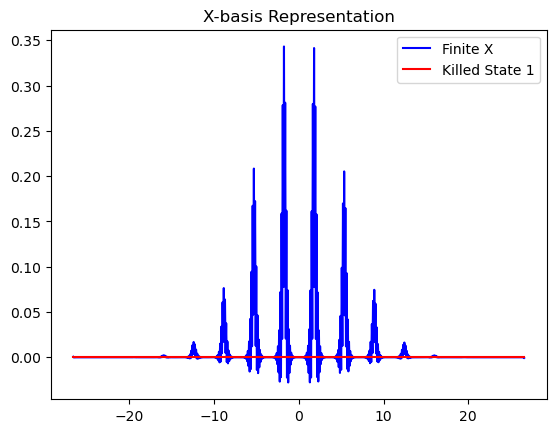

In [30]:
%%skip_if skip_xx

plt.plot(x_x,np.real(Psi_Ej_x),color='blue',label="Finite X")
plt.plot(x_x,np.real(d_j_E_xx[0]@Psi_Ej_x),color='red',label="Killed State 1")
# plt.plot(x_x,np.real(d_j_E_xx[1]@Psi_Ej_x),color='orange',label="Killed State 2")
plt.title("X-basis Representation")
plt.legend()
plt.show()

### Markovian Dynamics

In [31]:
%%skip_if skip_xx

H_E_n_xx = np.sqrt(Gamma)*(np.kron(d_j_E_xx[0],b_dag_k) + np.kron(d_j_E_dag_xx[0],b_k))
U_n_xx = sp.linalg.expm(-1j*np.sqrt(dt)*H_E_n_xx)

### Control Schemes

In [32]:
%%skip_if skip_xx

Psi_Ej_xp = np.kron(Psi_Ej_x,plus.T).flatten()

In [36]:
%%skip_if skip_xx

CD_A_xx = np.array([CD_xx(epsilon_j[j]*np.exp(1j*theta_j[j])) for j in [0,1]])
CD_B_xx = np.array([CD_xx(-1j*(alpha[j]+1j*beta[j])*c_Delta) for j in [0,1]])
CD_A2_xx = np.array([CD_xx(epsilon_j[j]*np.exp(1j*theta_j[j])/2) for j in [0,1]])

U_st_1_xx = np.array([(sp.linalg.expm(-1j*epsilon_j[j]/2*np.kron(x_j_perp_xx[j],Y_01)))@
                      (sp.linalg.expm(-1j*l_j[j]*c_Delta/2*np.kron(x_j_xx[j],X_01))) for j in [0,1]])
U_st_2_xx = np.array([(sp.linalg.expm(-1j*l_j[j]*c_Delta/2*np.kron(x_j_xx[j],X_01)))@
                      (sp.linalg.expm(-1j*epsilon_j[j]/2*np.kron(x_j_perp_xx[j],Y_01))) for j in [0,1]])

U_ST_1_xx = np.array([CD_A_xx[j]@(
                   np.kron(np.eye(N_x),np.conj(R_x(pi/2).T))@
                   CD_B_xx[j]) for j in [0,1]])
U_ST_2_xx = np.array([CD_B_xx[j]@(
                    np.kron(np.eye(N_x),R_x(pi/2))@
                    CD_A_xx[j]) for j in [0,1]])

U_sBs_xx = np.array([CD_A2_xx[j]@(
                    np.kron(np.eye(N_x),np.conj(R_x(pi/2).T))@(
                    CD_B_xx[j]@(
                    np.kron(np.eye(N_x),R_x(pi/2))@
                    CD_A2_xx[j])))for j in [0,1]])

## Verifying

#### Functions

In [34]:
def expect(op,state):
    if state.shape == op.shape:
        return np.trace(op@state)
    else:
        return np.dot(np.conj(state.T),op@state).flatten()
def dm2ket(dmi):
    U, S, Vh = np.linalg.svd(dmi)
    if not (np.isclose(1,S[0]) and np.allclose(np.conj(dmi.T),dmi)):
        print("States entangled. No simple tensor factoring.")
        return None
    return -np.conj(Vh[0,:]).T
def ptrace_b(dmi,n1,n2):
    new_mat = np.zeros((n1,n1),dtype=complex)
    I_n1 = np.eye(n1)
    for i in range(n2):
        vec = np.zeros((n2,1))
        vec[i] = 1
        new_mat += np.kron(I_n1,vec.T)@(dmi@np.kron(I_n1,vec))
    return new_mat
def remove_ancilla(state,Ni):
    state_2 = state.flatten()
    dmi = np.outer(state_2,np.conj(state_2))
    dm_clean = ptrace_b(dmi,Ni,2)
    return dm2ket(dm_clean)
def rk4_master(rhoi, dti):
    k1 = dti*master(rhoi)
    k2 = dti*master(rhoi+k1/2.)
    k3 = dti*master(rhoi+k2/2.)
    k4 = dti*master(rhoi+k3)
    rhoi = rhoi + 1./6*(k1+2*k2+2*k3+k4)
    return rhoi

#### Master Equation Evolution

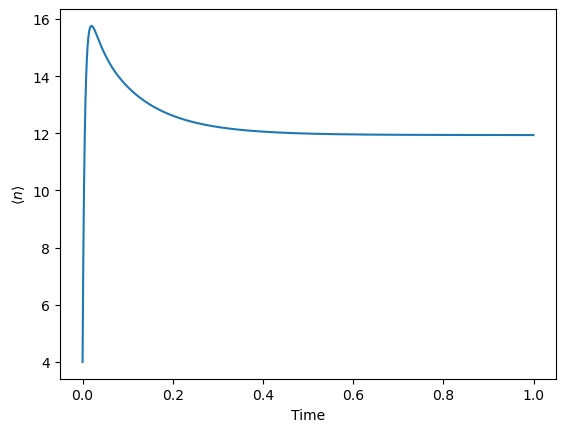

In [37]:
state_1_aa = np.zeros((N,1))
state_1_aa[4] = 1 # 8 fixes
dm_aa = np.outer(state_1_aa,np.conj(state_1_aa))
n_t_master = []
delta_t = .0001
times = np.arange(0,1,delta_t)
for ti in times:
    n_t_master.append(expect(n_hat_aa,dm_aa))
    dm_aa = rk4_master(dm_aa,delta_t)
    tr = np.trace(dm_aa)
    dm_aa = dm_aa/tr
plt.plot(times,np.real(n_t_master),label="Population")
plt.xlabel("Time")
plt.ylabel("$\\langle n \\rangle$")
plt.show()

#### Unitary Evolution

In [38]:
state_1_aa = np.zeros((N,1))
state_1_aa[4] = 1
dm_aa = np.outer(state_1_aa,np.conj(state_1_aa))
times = np.arange(0,10,dt)
dm_01 = np.outer(ket0,ket0)
dm_sys_aa01 = np.kron(dm_aa,dm_01)
n_t = []
for ti in times:
    dm_gkp_aa = ptrace_b(dm_sys_aa01,N,2) # kill ancilla qubit
    n_t.append(expect(n_hat_aa,dm_gkp_aa))
    dm_sys_aa01 = np.kron(dm_gkp_aa,dm_01) # reset ancilla
    dm_sys_aa01 = U_n_aa01@(dm_sys_aa01@U_n_dag_aa01)
    dm_sys_aa01 = dm_sys_aa01/np.trace(dm_sys_aa01)

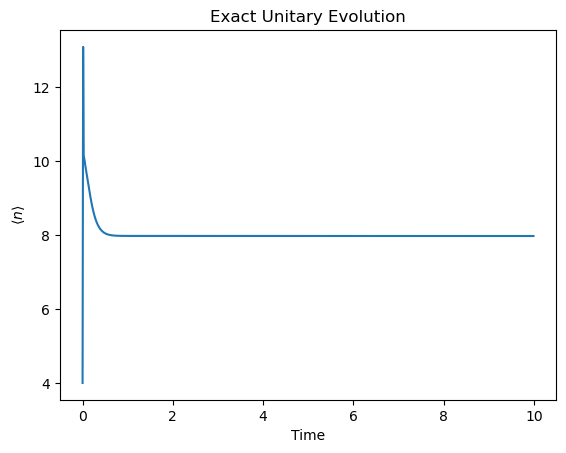

In [39]:
plt.plot(times,np.real(n_t),label="Population")
plt.xlabel("Time")
plt.ylabel("$\\langle n \\rangle$")
plt.title("Exact Unitary Evolution")
plt.show()

In [40]:
%%skip_if skip_xx
lat_print(r"$\langle i | a| i\rangle_x = 0$?")
print(np.isclose(0,np.real(expect(a_xx,Psi_Ej_x))))
lat_print(fr"$\Gamma = {np.round(Gamma,3)}$")
lat_print(fr"$\delta t = {np.round(dt,3)}$")
lat_print(fr"$\delta t \Gamma = {np.round(Gamma*dt,3)}$")

<IPython.core.display.Latex object>

[ True]


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

#### Sharpen-Trim

In [41]:
state_1_aa = np.zeros((N,1))
state_1_aa[0] = 1
dm_aa = np.outer(state_1_aa,np.conj(state_1_aa))
times = np.arange(0,10,dt)
dm_01 = np.outer(plus,plus)
dm_sys_aa01 = np.kron(dm_aa,dm_01)
n_t_st = [0]
for i,ti in enumerate(times): 
    if i % 2 == 0:
        dm_sys_aa01 = U_ST_1_aa01[0]@(dm_sys_aa01@U_ST_1_dag_aa01[0]) # sharpen
    else: 
        dm_sys_aa01 = U_ST_2_aa01[0]@(dm_sys_aa01@U_ST_2_dag_aa01[0]) # trim
    dm_sys_aa01 = dm_sys_aa01/np.trace(dm_sys_aa01)
    if i % 2 == 1:
        dm_gkp_aa = ptrace_b(dm_sys_aa01,N,2) # kill ancilla qubit
        n_t_st.append(expect(n_hat_aa,dm_gkp_aa))
        dm_sys_aa01 = np.kron(dm_gkp_aa,dm_01) # reset ancilla

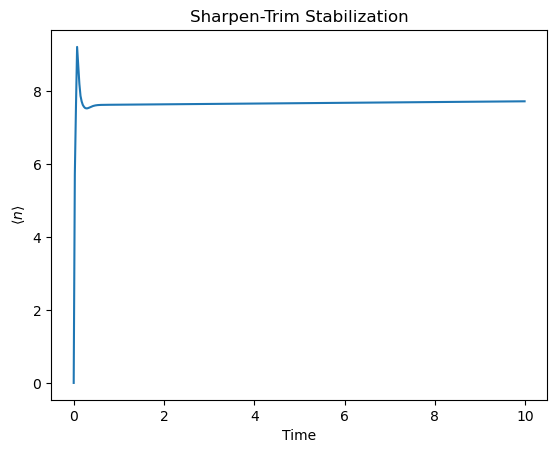

In [42]:
plt.plot(times[::2],np.real(n_t_st),label="Population")
plt.xlabel("Time")
plt.ylabel("$\\langle n \\rangle$")
plt.title("Sharpen-Trim Stabilization")
plt.show()

#### Small-Big-Small

In [43]:
state_1_aa = np.zeros((N,1))
state_1_aa[0] = 1
dm_aa = np.outer(state_1_aa,np.conj(state_1_aa))
times = np.arange(0,10,dt)
dm_01 = np.outer(plus,plus)
dm_sys_aa01 = np.kron(dm_aa,dm_01)
n_t_sbs = []
for ti in times:
    dm_gkp_aa = ptrace_b(dm_sys_aa01,N,2) # kill ancilla qubit
    n_t_sbs.append(expect(n_hat_aa,dm_gkp_aa))
    dm_sys_aa01 = np.kron(dm_gkp_aa,dm_01) # reset ancilla
    dm_sys_aa01 = U_sBs_aa01[0]@(dm_sys_aa01@np.conj(U_sBs_aa01[0].T))

    dm_sys_aa01 = dm_sys_aa01/np.trace(dm_sys_aa01)

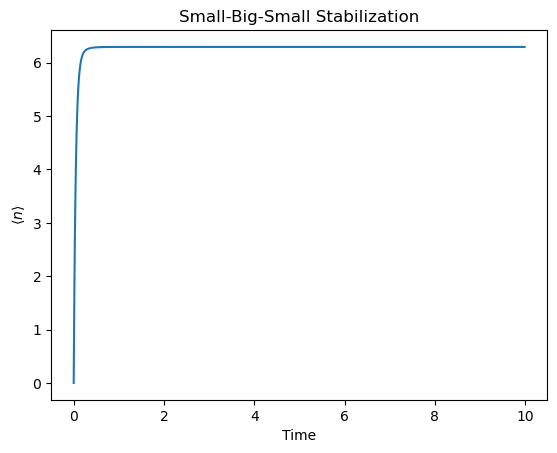

In [44]:
plt.plot(times,np.real(n_t_sbs),label="Population")
plt.xlabel("Time")
plt.ylabel("$\\langle n \\rangle$")
plt.title("Small-Big-Small Stabilization")
plt.show()